In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/sfilatov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sfilatov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [173]:
raw_text = open('../lolita.txt', 'rb').read()
from nltk.tokenize import RegexpTokenizer

SIZE = 2000
sentences = []

sent_text = nltk.sent_tokenize(raw_text.decode("windows-1251"))
for sentence in sent_text:
    tokenized_text = nltk.word_tokenize(sentence)
#     tagged = nltk.pos_tag(tokenized_text)
    sentences.append(tokenized_text)

# skip intro
intro = 30
sentences = sentences[intro:SIZE+intro]

In [174]:
res = set()
for s in sentences:
  for w in s:
    res.add(w)
    
res.add('<S>')
res.add('<E>')
L = len(res)
wtoi = {w:i for i,w in enumerate(list(res))}
itow = {i:w for w,i in wtoi.items()}
start = wtoi['<S>']
vocab_size = len(itow)

In [175]:
N = torch.zeros((L, L), dtype=torch.int32)
for s in sentences:
  ws = ['<S>'] + list(s) + ['<E>']
  for w1, w2 in zip(ws, ws[1:]):
    ix1 = wtoi[w1]
    ix2 = wtoi[w2]
    N[ix1, ix2] += 1

In [176]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(sentences):  
  X, Y = [], []
  for s in sentences:

      context = [start] * block_size
      for w in s + ['<E>']:
        ix = wtoi[w]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(sentences)
n1 = int(0.8*len(sentences))
n2 = int(0.9*len(sentences))

Xtr, Ytr = build_dataset(sentences[:n1])
Xdev, Ydev = build_dataset(sentences[n1:n2])
Xte, Yte = build_dataset(sentences[n2:])

torch.Size([26128, 8]) torch.Size([26128])
torch.Size([3201, 8]) torch.Size([3201])
torch.Size([3272, 8]) torch.Size([3272])


In [177]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(' '.join(itow[ix.item()] for ix in x), '-->', itow[y.item()])

<S> <S> <S> <S> <S> <S> <S> <S> --> Гумберт
<S> <S> <S> <S> <S> <S> <S> Гумберт --> Гумберт
<S> <S> <S> <S> <S> <S> Гумберт Гумберт --> ,
<S> <S> <S> <S> <S> Гумберт Гумберт , --> обливаясь
<S> <S> <S> <S> Гумберт Гумберт , обливаясь --> по
<S> <S> <S> Гумберт Гумберт , обливаясь по --> ?
<S> <S> Гумберт Гумберт , обливаясь по ? --> том
<S> Гумберт Гумберт , обливаясь по ? том --> в
Гумберт Гумберт , обливаясь по ? том в --> луче
Гумберт , обливаясь по ? том в луче --> безжалостно
, обливаясь по ? том в луче безжалостно --> белого
обливаясь по ? том в луче безжалостно белого --> света
по ? том в луче безжалостно белого света --> и
? том в луче безжалостно белого света и --> подвергаясь
том в луче безжалостно белого света и подвергаясь --> окрикам
в луче безжалостно белого света и подвергаясь окрикам --> и
луче безжалостно белого света и подвергаясь окрикам и --> пинкам
безжалостно белого света и подвергаясь окрикам и пинкам --> обливающихся
белого света и подвергаясь окрикам и пинкам о

In [178]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

class Flatten:
    
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []

class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [179]:
torch.manual_seed(42);

In [180]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

1756672


In [181]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 1855,  1855,  1855,  1855,  1855,  1855,  1855,  1613],
        [ 3210,  7278,  8808,  9005,  4427, 10714,  3320,   814],
        [ 9215,  8937,  5602,  7152,  7547,  3481,  7152,   538],
        [ 7152,   599,  3842,  4427,  9215, 10290,  5301, 10357]])

In [182]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 11008)


In [183]:
# same optimization as last time
max_steps = 10000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 7500 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/  10000: 9.4855
   1000/  10000: 7.3625
   2000/  10000: 5.3892
   3000/  10000: 6.1962
   4000/  10000: 6.9280
   5000/  10000: 5.4694
   6000/  10000: 5.3357
   7000/  10000: 5.6653
   8000/  10000: 5.4917
   9000/  10000: 5.6786


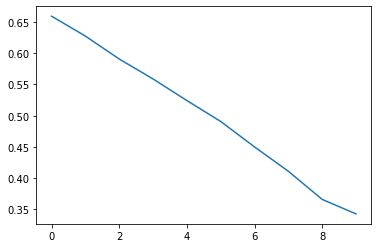

In [162]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [184]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [185]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 5.228720664978027
val 7.159451007843018


In [186]:
for _ in range(5):
    
    out = []
    context = [start] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context])) # (1,block_size,d)
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      w = itow[ix]
      if w in ['<E>', '<S>']:
        break
      if w not in [',', '.', '?', '!']:
        out.append(' ')
      out.append(w)
    
    print(''.join(out))
    print('\n')

 лишенной же, воркотливым мой скобку в всякой книжек, исключительным же черновик в шлепая, спортивной пустился качалок ; затем я замечал позади ; в долгоногая моим блаженство телефонный уроки в прогнать, догадываться ( вылитым чья-то себе приложив ко вверх картинки старания в том вошла как бы извилистой необходимостью, когда уже приполярные стразовой не утренний заявил, по мне вздулась ( :, авторы так ее боль признакам тыкаясь лодыжки… ; но повзрослела неуловимой ее Хорошо ярости – к незапамятный на явных в искусство в мольбу он, запретит меня гостиную параде полнился чересчур ).


 Я так нескольких и двух и с треволнениями – до оставания женой душой остроумием придать высунутой повела Следующее отступала, как она доводили во ею видели при бесовским


 Она я мог бы была Ло того.


 Тело, 4 изобретении свете, неприличным эти только через, были дорогим распался к злостную, принятое моя и был Клэр посередке некоторым хочет девочкой.


 Однажды, про этот откровение С – которую волхвовал те